# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


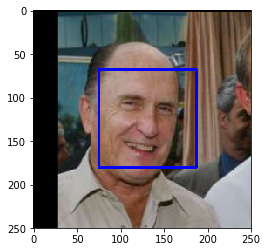

In [5]:
import cv2               
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ Percentage of humans correctly classified as people: 99%
Percentage of dogs misclassified as people: 12%

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_cnt=0
dog_cnt=0
for i in range(99):
    if face_detector(human_files[i])==True:
        human_cnt+=1
    if face_detector(dog_files_short[i])==True:
        dog_cnt+=1
print('Percentage of humans correctly classified as people: {}%'.format(human_cnt))
print('Percentage of dogs misclassified as people: {}%'.format(dog_cnt))



Percentage of humans correctly classified as people: 99%
Percentage of dogs misclassified as people: 12%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__The requirement of having only pictures with clearly presented faces makes sense for this use case, but the requirement should be clearly communicated. For other use cases, when detecting humans in pictures, the algorithm could be trained to detect non-frontal face pictures.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [8]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
def custom_face_detector(img_path):
    return True

custom_face_detector_accuracy_human = np.mean(list(map(custom_face_detector, human_files_short)))

custom_face_detector_accuracy_dog   = np.mean(list(map(custom_face_detector,   dog_files_short)))


print("custom_face_detector accuracy on humans: {}%".format(custom_face_detector_accuracy_human * 100))

print("custom_face_detector accuracy on dogs: {}%".format(custom_face_detector_accuracy_dog * 100))

custom_face_detector accuracy on humans: 100.0%
custom_face_detector accuracy on dogs: 100.0%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ percentage of the images in human_files_short have a detected dog: 0% & 
percentage of the images in dog_files_short have a detected dog: 99%

In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
hmn_p=0
dog_p=0
for i in range(99):
    if dog_detector(human_files_short[i])==True:
        hmn_p+=1
    if dog_detector(dog_files_short[i])==True:
        dog_p+=1
print('percentage of the images in human_files_short that have a detected dog: {}%'.format(hmn_p))
print('percentage of the images in dog_files_short that have a detected dog: {}%'.format(dog_p))




percentage of the images in human_files_short that have a detected dog: 0%
percentage of the images in dog_files_short that have a detected dog: 99%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 100.02it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ Here I'm using the architecture defined above. The initial convolution layers generally learn the edges and blobs. Afterwards the the convolution layers begin to be specific for our given dataset. The max pooling layers downsample the output of previous convolution layers by taking the maximum value from a region and also help reduce overfitting, since it propagates an approximation of the convolution filter.
So both of these( convolution and max pooling) creates a very complex pattern in order to detect dog breeds.The global average pooling layer takes the average value of each feature map learned. In order to get the output we use the dense layer in the end with softmax activation function. This gives the predicted category(here breed) of the dog.


In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

### TODO: Define your architecture.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
__________

### Compile the Model

In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [15]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 208s 31ms/step - loss: 4.8830 - acc: 0.0084 - val_loss: 4.8695 - val_acc: 0.0120

Epoch 00001: val_loss improved from inf to 4.86950, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
6680/6680 [==============================] - 208s 31ms/step - loss: 4.8668 - acc: 0.0096 - val_loss: 4.8529 - val_acc: 0.0132

Epoch 00002: val_loss improved from 4.86950 to 4.85287, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/10
6680/6680 [==============================] - 207s 31ms/step - loss: 4.8458 - acc: 0.0148 - val_loss: 4.8342 - val_acc: 0.0132

Epoch 00003: val_loss improved from 4.85287 to 4.83422, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/10
6680/6680 [==============================] - 205s 31ms/step - loss: 4.8027 - acc: 0.0187 - val_loss: 4.7969 - val_acc: 0.0204

Epoch 00004: val_loss improved from 4.83422 to 4.79687, s

### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.4689%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [17]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [18]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [19]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 570us/step - loss: 12.1721 - acc: 0.1235 - val_loss: 10.5254 - val_acc: 0.2204

Epoch 00001: val_loss improved from inf to 10.52541, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 205us/step - loss: 9.8043 - acc: 0.2877 - val_loss: 9.6830 - val_acc: 0.3054

Epoch 00002: val_loss improved from 10.52541 to 9.68298, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 208us/step - loss: 9.2294 - acc: 0.3573 - val_loss: 9.3319 - val_acc: 0.3305

Epoch 00003: val_loss improved from 9.68298 to 9.33185, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 206us/step - loss: 8.8804 - acc: 0.3951 - val_loss: 9.1831 - val_acc: 0.3533

Epoch 00004: val_loss improved from 9.33185 to 9.18315, saving model to saved_

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 49.0431%


### Predict Dog Breed with the Model

In [20]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [21]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ The Resnet50 model was already pre-trained for the compatible ImageNet dataset. Since we are using transfer learning so we need to add a GAP(global average pooling layer) which just basically gets the average value of every feature map. Since we have 133 categories so we use a dense layer in the end with a softmax activation function. This dense layer in the end gives us the output or prediction resut. 

From the visualisation of the training history of the model we get two graphs which have been implemented in 29th row.
The model accuracy graph shows accuracy vs epoch relation. From this we can clearly see that the accuracy of the training model on the training dataset is very high as compared to the validation dataset. So this shows that the model is overfitting.
The model loss graph shows the loss per epoch of model on training and validation dataset. Here also we see that the loss increses on the validation dataset but it decreses on the training dataset.

But still this outperforms the previous models implemented from scratch as this model uses transfer learning. We know that in transfer learning the first few layers contains features like edges, globs etc which are generalised for all. So we use it till that layer and afterwards we add other layers(mentioned above) on the top layer. Another reason for this model to be better than others is that it was pre tained on a huge dataset but our previous models were trained on small dataset which resulted in a very poor accuracy.


In [22]:
### TODO: Define your architecture.

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [23]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [28]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint 
epochs = 60

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

history=Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/60
6680/6680 [==============================] - 2s 262us/step - loss: 0.2048 - acc: 0.9358 - val_loss: 0.6906 - val_acc: 0.8228

Epoch 00001: val_loss improved from inf to 0.69055, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 2/60
6680/6680 [==============================] - 2s 273us/step - loss: 0.1256 - acc: 0.9605 - val_loss: 0.7474 - val_acc: 0.7976

Epoch 00002: val_loss did not improve from 0.69055
Epoch 3/60
6680/6680 [==============================] - 2s 271us/step - loss: 0.0921 - acc: 0.9711 - val_loss: 0.6921 - val_acc: 0.8275

Epoch 00003: val_loss did not improve from 0.69055
Epoch 4/60
6680/6680 [==============================] - 2s 263us/step - loss: 0.0683 - acc: 0.9789 - val_loss: 0.6761 - val_acc: 0.8311

Epoch 00004: val_loss improved from 0.69055 to 0.67611, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 5/60
6680/6680 [==============================] - 2s 283us/step - loss: 0.052


Epoch 00043: val_loss did not improve from 0.67611
Epoch 44/60
6680/6680 [==============================] - 2s 248us/step - loss: 0.0052 - acc: 0.9988 - val_loss: 1.1377 - val_acc: 0.8299

Epoch 00044: val_loss did not improve from 0.67611
Epoch 45/60
6680/6680 [==============================] - 2s 245us/step - loss: 0.0034 - acc: 0.9985 - val_loss: 1.1587 - val_acc: 0.8347

Epoch 00045: val_loss did not improve from 0.67611
Epoch 46/60
6680/6680 [==============================] - 2s 245us/step - loss: 0.0050 - acc: 0.9985 - val_loss: 1.1386 - val_acc: 0.8299

Epoch 00046: val_loss did not improve from 0.67611
Epoch 47/60
6680/6680 [==============================] - 2s 256us/step - loss: 0.0047 - acc: 0.9987 - val_loss: 1.1629 - val_acc: 0.8263

Epoch 00047: val_loss did not improve from 0.67611
Epoch 48/60
6680/6680 [==============================] - 2s 253us/step - loss: 0.0046 - acc: 0.9982 - val_loss: 1.1446 - val_acc: 0.8311

Epoch 00048: val_loss did not improve from 0.67611
Epo

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


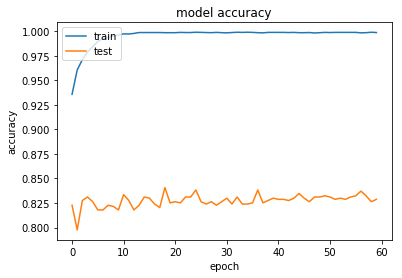

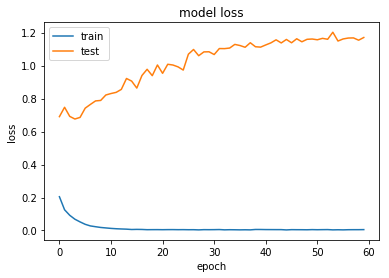

In [29]:
#Visualizaation of training history of the model

#List all data in history
print(history.history.keys())

#summerise history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#Summerise history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [30]:
### TODO: Load the model weights with the best validation loss.

### DONE: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [31]:
### TODO: Calculate classification accuracy on the test dataset.
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.3397%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [32]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)[0]
    # return dog breed that is predicted by the model
    
    breeds_predicted = [dog_names[idx] for idx in np.argsort(predicted_vector)[::-1][:2]]  #Two most probable breeds
    confidence_predicted = np.sort(predicted_vector)[::-1][:2]                           #Probabilty of those breeds
    return breeds_predicted,confidence_predicted


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [33]:
#Extras
#Snapchat Like Dog Filter for humans
dog=cv2.imread('dog_filter.png')
def put_dog_filter(dog,fc,x,y,w,h):
    face_width = w
    face_height = h
    
    dog = cv2.resize(dog,(int(face_width*1.5),int(face_height*1.75)))
    for i in range(int(face_height*1.75)):
        for j in range(int(face_width*1.5)):
            for k in range(3):
                if dog[i][j][k]<235:
                    fc[y+i-int(0.375*h)-1][x+j-int(0.25*w)][k] = dog[i][j][k]
    return fc

def apply_filter(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(40,40)
    )
    
    for (x, y, w, h) in faces:
        frame = put_dog_filter(dog,img,x,y,w,h)
    cv_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print("Human with dog filter")
    plt.imshow(cv_rgb)
    plt.show()

In [34]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def algo(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    print("File Path: ",img_path)
    print("\n")
    breeds,prob =Resnet50_predict_breed(img_path) 
    if face_detector(img_path)==True:
        print("Human face detected. Resembling dog breed is ",breeds[0])
        print("\n\n")
        apply_filter(img) #Snapchat like dog filter
    elif dog_detector(img_path)==True:
        print("Dog detected. Breed is ", breeds[0])
        print("\n")
        #check for cross breeds
        if (prob[0]-prob[1])*100 <=10:
            print("If this is a cross then it can be between "+breeds[0]+"("+str(prob[0]*100)+"%)"+" and "+breeds[1]+"("+str(prob[1]*100)+"%)")
        print("\n\n")
    else:
        print("Error. The image isn't of a human or a dog")
        print("\n\n")


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The algorithm works as expected. Most of the images were classified correctly except last one which was actually a cross breed of cocker spaniel and poodle. It was misclassified as Portuguese_water_dog but that's alright since it's even very difficult for a human to distinguish between these two breeds as they look almost similar. I even tried this algorithm with a cat image but it wasn't misclassified at all. So the algorithm works pretty well. Also it detected the humans corretly.

Also I have tried to detect cross breeds by taking the difference of two top most predicted breeds and if that difference is less than some threshold value say 10 or 8 then it's a cross between them.

For making the porject more interesting I tried implementing snapchat like dog filters (using opencv) on human images.

Points of imporvement:
1.I have noticed that the algorithm takes quite a bit of time say 1 to 2 min to predict. So I guess the model should be improved in order to decrese this prediction time.
2.The algorithm should be designed in such a way so that it can detect dogs and identify them in a video(in real time)
3.It should detect the dogs and identify the breeds from live webcam or other cameras.
4.Also classify dogs from images available on websites i.e URLs or from cloud data.


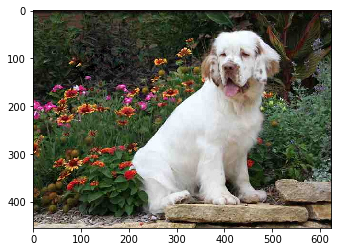

File Path:  my_images/clumber_spaniel.jpeg


Dog detected. Breed is  Clumber_spaniel







In [137]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
files = np.array(glob("my_images/*"))
algo(files[0]) #clumber spaniel


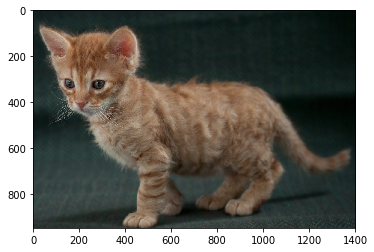

File Path:  my_images/American-wirehair-cats_10.jpg


Error. The image isn't of a human or a dog





In [122]:
algo(files[1]) #cat

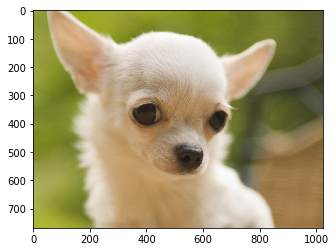

File Path:  my_images/chihuahua.jpeg


Dog detected. Breed is  Chihuahua







In [138]:
algo(files[2]) #chihuahua

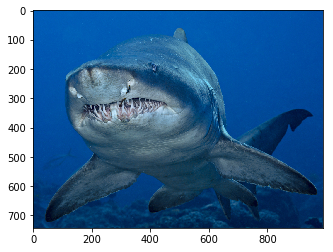

File Path:  my_images/shark.jpeg


Error. The image isn't of a human or a dog





In [124]:
algo(files[3]) #shark

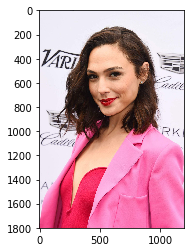

File Path:  my_images/gal_gadot.jpeg


Human face detected. Resembling dog breed is  English_toy_spaniel



Human with dog filter


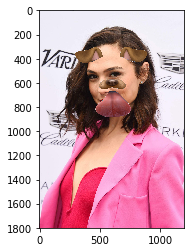

In [126]:
algo(files[5]) #human

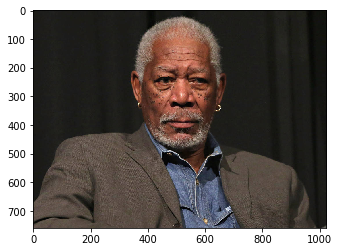

File Path:  my_images/morgan_freeman.jpeg


Human face detected. Resembling dog breed is  Xoloitzcuintli



Human with dog filter


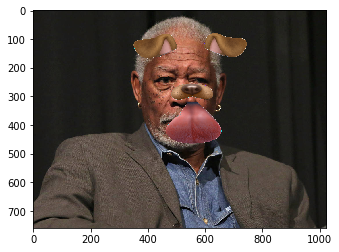

In [127]:
algo(files[6]) #human

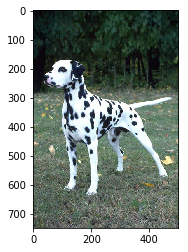

File Path:  my_images/Dalmatian-Care-500x749.jpg


Dog detected. Breed is  Dalmatian







In [139]:
algo(files[7]) #Dalmatian

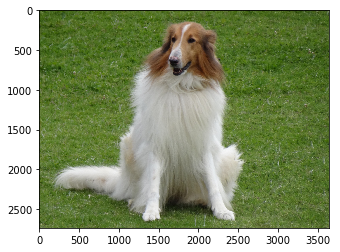

File Path:  my_images/collie.jpeg


Dog detected. Breed is  Collie







In [140]:
algo(files[8]) #Collie

In [130]:
br1 = np.array(glob("dogImages/test/*/*"))

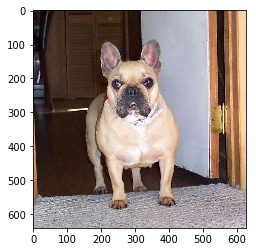

File Path:  dogImages/test/069.French_bulldog/French_bulldog_04813.jpg


Dog detected. Breed is  French_bulldog







In [141]:
algo(br1[5])

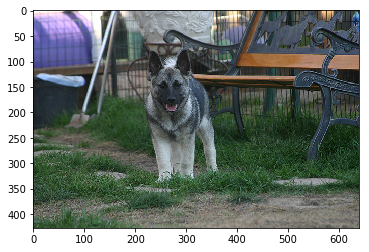

File Path:  dogImages/test/109.Norwegian_elkhound/Norwegian_elkhound_07132.jpg


Dog detected. Breed is  Norwegian_elkhound







In [142]:
algo(br1[89])

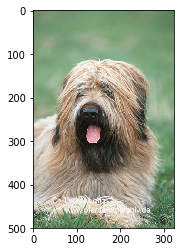

File Path:  dogImages/test/036.Briard/Briard_02539.jpg


Dog detected. Breed is  Briard







In [143]:
algo(br1[45])

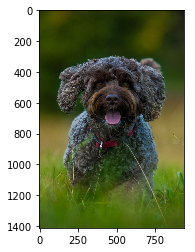

File Path:  my_images/cockapoo.jpg


Dog detected. Breed is  Portuguese_water_dog







In [146]:
algo("my_images/cockapoo.jpg") #cross breed of cocker_spaniel & poodle

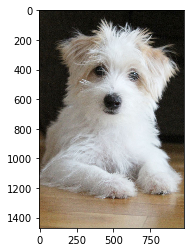

File Path:  my_images/morkie.jpg


Dog detected. Breed is  Chinese_crested


If this is a cross then it can be between Chinese_crested(20.597927272319794%) and Maltese(19.8099285364151%)





In [149]:
algo("my_images/morkie.jpg") #cross breed

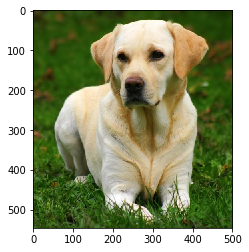

File Path:  my_images/Labrador_retriever_06457.jpg


Dog detected. Breed is  Labrador_retriever







In [151]:
algo("my_images/Labrador_retriever_06457.jpg")